In [2]:
"""
    Notebook to explore embedding space for members and non-members for few-shot learning to see if any useful trends exist that can be utilized
    by adversary.
"""
# Extension re-loading
%load_ext autoreload
%autoreload 2

In [3]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [4]:
import torch as ch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from distribution_inference.datasets.utils import get_dataset_wrapper
from distribution_inference.config.core import DatasetConfig, RelationConfig
from dataclasses import replace

from distribution_inference.training.utils import load_model
import distribution_inference.models.contrastive as models_contrastive
from distribution_inference.attacks.blackbox.utils import get_relation_preds
from distribution_inference.training.relation_net import validate_epoch

from tqdm import tqdm
import torchvision.transforms as transforms
import kornia.augmentation as kor_aug

# Set DPI to 300 for better quality
plt.rcParams['figure.dpi'] = 200

In [39]:
@ch.no_grad()
def collect_embeddings(model, loader, squeeze: bool = True):
    """
        Collect embeddings for a given model and loader
    """
    embeddings, labels = [], []
    for batch in tqdm(loader, desc="Collecting embeddings"):
        embed = model(batch[0].cuda(), embedding_mode=True).detach().cpu().numpy()
        embeddings.append(embed)
        labels.append(batch[1].numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    # Flatten out embeddings:
    if squeeze:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

In [23]:
def look_at_metrics(embeds):
    """
        Helper function to look at the metrics studied in https://arxiv.org/abs/2203.02077
        to see if they seem to be of use
    """
    centroid = np.mean(embeds, axis=0)
    # Distances from all points to centroid
    dists = np.linalg.norm(embeds - centroid, axis=1)
    dists = dists.mean()
    # Distances from all points to each other
    dists2 = np.linalg.norm(embeds[:, None] - embeds[None, :], axis=2)
    dists2 = dists2.mean()
    return dists, dists2

In [56]:
@ch.no_grad()
def look_at_relational_metrics(model, embeds):
    """
        Similar to looking at metrics, but using the model explicitly to compute distances,
        instead of L2 norm.
    """
    embeds_ = ch.from_numpy(embeds)
    centroid = ch.mean(embeds_, 0).unsqueeze(0).repeat(len(embeds), 1, 1, 1)
    combined = ch.cat((centroid, embeds_), 1)
    dists = model(combined.cuda(), embedding_mode=False).detach().mean().cpu().item()
    # Distances from all points to each other
    dists2 = []
    for i in range(embeds_.shape[0]-1):
        others = embeds_[i+1:]
        this = embeds_[i].unsqueeze(0).repeat(others.shape[0], 1, 1, 1)
        combined = ch.cat((others, this), 1)
        dists_ = model(combined.cuda(), embedding_mode=False).detach()
        dists2.extend(dists_)
    dists2 = ch.mean(ch.cat(dists2)).cpu().item()
    return 1 - dists, 1 - dists2

In [ ]:
def embedding_study(ds_adv, ds_victim,
                    victim_model_path: str,
                    batch_size: int = 128,
                    n_people: int = 5,
                    skip_plot: bool = False):
    """
        Look at embedding distances between clusters of pairs of images of people.
        Intiution: member subjects would be clustered more tightly.
    """
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Collect embeddings
    member_embeds, member_labels = collect_embeddings(victim_model, loader_members)
    nonmember_embeds, nonmember_labels = collect_embeddings(victim_model, loader_nonmembers)

    def _within(x, y):
        centroids = []
        spreads = []
        for y_ in np.unique(y):
            selected = x[y == y_]
            centroid = np.mean(selected, axis=0)
            dists = np.linalg.norm(selected - centroid, axis=1).mean()
            centroids.append(centroid)
            spreads.append(dists)
        return np.array(centroids), np.mean(spreads)

    member_wise_centre, member_wise_spread = _within(member_embeds, member_labels)
    nonmember_wise_centre, nonmember_wise_spread = _within(nonmember_embeds, nonmember_labels)

    # Look at pair-wise distances between elements of member_wise_centre
    member_centre_dist = []
    for i in range(member_wise_centre.shape[0] - 1):
        # print(member_wise_centre[i].shape, member_wise_centre[i+1:].shape)
        member_centre_dist.extend(np.linalg.norm(member_wise_centre[i] - member_wise_centre[i+1:], axis=1))
    member_centre_dist = np.array(member_centre_dist)
    # Look at pair-wise distances between elements of nonmember_wise_centre
    nonmember_centre_dist = []
    for i in range(nonmember_wise_centre.shape[0] - 1):
        nonmember_centre_dist.extend(np.linalg.norm(nonmember_wise_centre[i] - nonmember_wise_centre[i+1:], axis=1))
    nonmember_centre_dist = np.array(nonmember_centre_dist)
    # Look at distance between elements of member_wise_centre and nonmember_wise_centre
    member_nonmember_centre_dist = []
    for i in range(member_wise_centre.shape[0]):
        member_nonmember_centre_dist.extend(np.linalg.norm(
            member_wise_centre[i] - nonmember_wise_centre, axis=1))
    member_nonmember_centre_dist = np.array(member_nonmember_centre_dist)
    
    print(f"Member distances: {member_centre_dist.mean()}, spreads: {member_wise_spread}")
    print(f"Nonmember distances: {nonmember_centre_dist.mean()}, spreads: {nonmember_wise_spread}")
    print(f"Member-nonmember distances: {member_nonmember_centre_dist.mean()}")

    return member_centre_dist, nonmember_centre_dist, member_nonmember_centre_dist

In [ ]:
def relational_aug_experiment(ds_adv, ds_victim,
                          victim_model_path: str,
                          batch_size: int = 128,
                          n_people: int = 5,
                          n_support: int = 5,
                          n_way: int = 5,
                          n_times: int = 5,):
    """
        Look at change in model predictions when query images are replaced with augmented verions of the 
        same image (based on random erasing). Idea: member subjects might be slightly "memorized" by model
        and it might retain higher accuracy for such subjects.
    """
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(
        victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Crop-based transform
    transform = kor_aug.RandomErasing(scale=(0.15, 0.2), p=1)

    def _collect_matching(loader):
        mapping = {}
        for batch in loader:
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping
    
    def kl_div(x, y):
        eps = 1e-6
        x_ = x + eps
        y_ = y + eps
        # Compute kl divergence
        return (x_ * np.log(x_ / y_)).sum()

    def _treatment(map):
        relation_vals = []
        for k, v in tqdm(map.items(), desc="Collecting relation values"):
            # Create support
            other_people = list(set(map.keys()) - {k})
            other_people = np.random.choice(other_people, size=n_way - 1, replace=False)
            this_images = v
            support_images = [this_images[:n_support].cuda()]
            for o in other_people:
                random_choice = np.random.choice(
                    len(map[o]), size=n_support, replace=False)
                # Randomly n_support from map[o]
                support = map[o][random_choice]
                support_images.append(support.cuda())

            # Use last n_support images as query
            query_images = this_images[n_support:]
            n_query = len(query_images)
            # Get preds on untransformed query images
            with ch.no_grad():
                og_relation_values = get_relation_preds(support_images, query_images.cuda(), victim_model).cpu().numpy()
            
            # Apply transform n_times to each query image
            query_images = (query_images + 1) / 2
            collected = []
            for i in range(n_times):
                collected.append(transform(query_images))
            query_images = ch.cat(collected, 0)
            # query shape: (n_times * n_query, 3, 96, 96)
            # Bring back to (-1, 1) normalization
            query_images = ((query_images - 0.5) * 2)

            with ch.no_grad():
                relation_values = get_relation_preds(support_images, query_images.cuda(), victim_model).cpu().numpy()
            # Shape: (n_times * n_query, n_way)
            relation_values = relation_values.reshape(n_query, n_times, n_way)
            # Get mean KL divergence between og_relation_values (per image), and each transformed version
            inside = []
            for i in range(n_query):
                relations = relation_values[i]
                og_relations = og_relation_values[i]
                inside.append(np.mean([kl_div(og_relations, relations[j]) for j in range(n_times)]))
            relation_vals.append(np.mean(inside))

        return np.array(relation_vals)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals


In [ ]:
def output_analysis(ds_adv, ds_victim,
                    victim_model_path: str,
                    batch_size: int = 128,
                    n_people: int = 5,
                    n_support: int = 5,
                    n_way: int = 5):
    """
        Pure inspection of model predictions
    """
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(
        victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    def _collect_matching(loader):
        mapping = {}
        for batch in tqdm(loader, desc="Split into people"):
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    def _treatment(map):
        relation_vals = []
        similarities = []
        for k, v in tqdm(map.items(), desc="Collecting relation values"):
            embeds_person = victim_model(v.cuda(), embedding_mode=True).detach().cpu()
            for i in range(len(embeds_person) - 1):
                others = embeds_person[i+1:]
                repeated_i = embeds_person[i].unsqueeze(0).repeat(len(others), 1, 1, 1)
                # Also keep track of cosine similarity
                # similarities.extend(ch.cosine_similarity(repeated_i, others).cpu().detach().numpy())
                # combined = ch.cat((others, repeated_i), 1)
                combined = ch.cat((repeated_i, others), 1)
                wanted_relation_values = victim_model(combined.cuda(), embedding_mode=False)
                relation_vals.extend(wanted_relation_values.cpu().detach().numpy())
        return np.array(relation_vals)
        # return np.array(similarities)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals

In [79]:
def relational_experiment(ds_adv, ds_victim,
                          victim_model_path: str,
                          batch_size: int = 128,
                          n_people: int = 5,
                          n_support: int = 5,
                          n_way: int = 5,
                          collect_ind: bool = False,
                          normalized_preds: bool = False):
    """
        Look at model relation outputs between query images and support images for ground truth.
        Since this is the feature vector used in Face-Audit, should have some useful signal beneath it?
    """
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(
        victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(
        train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    _, loader_nonmembers = ds_adv.get_loaders(
        shuffle=True, batch_size=batch_size, primed_for_training=False)

    def _collect_matching(loader):
        mapping = {}
        for batch in loader:
            img = batch[0]
            lbl = batch[1]
            for i, l in enumerate(lbl):
                l_ = l.item()
                if l_ not in mapping:
                    mapping[l_] = []
                mapping[l_].append(img[i])
        for k in mapping.keys():
            mapping[k] = ch.stack(mapping[k])
        return mapping

    def _treatment(map):
        relation_vals = []
        for k, v in tqdm(map.items(), desc="Collecting relation values"):
            # Pick n_way - 1 other people randomly from map.keys()
            other_people = list(set(map.keys()) - {k})
            other_people = np.random.choice(other_people, size=n_way - 1, replace=False)
            this_images = v
            # Pick first n_support images from this_images
            if collect_ind:
                support_images = [x.unsqueeze(0).cuda() for x in this_images[:n_support]]
            else:
                support_images = [this_images[:n_support].cuda()]
            for o in other_people:
                random_choice = np.random.choice(len(map[o]), size=n_support, replace=False)
                # Randomly n_support from map[o]
                support = map[o][random_choice]
                if collect_ind:
                    for x in support:
                        support_images.append(x.unsqueeze(0).cuda())
                else:
                    support_images.append(support.cuda())
            query_images = this_images[n_support:].cuda()
            relation_values = get_relation_preds(support_images, query_images, victim_model)
            if collect_ind:
                wanted_relation_values = relation_values[:, :n_support]
            else:
                if normalized_preds:
                    relation_values = ch.softmax(relation_values, dim=1)
                #wanted_relation_values = relation_values[:, 0]
                wanted_relation_values = ch.stack((relation_values[:, 0], ch.mean(relation_values[:, 1:], 1)), 1)
                
                #largest_otherwise = ch.max(relation_values[:, 1:], dim=1).values
                #wanted_relation_values -= largest_otherwise

            relation_vals.extend(wanted_relation_values.cpu().numpy())
        return np.array(relation_vals)

    member_map = _collect_matching(loader_members)
    nonmember_map = _collect_matching(loader_nonmembers)

    member_vals = _treatment(member_map)
    nonmember_vals = _treatment(nonmember_map)

    return member_vals, nonmember_vals

In [70]:
def experiment(ds_adv, ds_victim,
               victim_model_path: str,
               batch_size: int = 128,
               n_people: int = 5,
               skip_plot: bool = False,
               tsne_dim: int = 2,
               use_relation: bool = False):
    """
        Analysis of embeddings in projected space to see if any useful trends emerge.
    """
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Sample from train_people to pick random people
    train_people = np.random.choice(train_people, size=n_people, replace=False)

    # Get loader for victim that contains train people
    loader_members = ds_victim.get_specified_loader(train_people, shuffle=True, batch_size=batch_size)
    # Get loader for adversary (use test people for now)
    loader_nonmembers, _ = ds_adv.get_loaders(shuffle=True, batch_size=batch_size, primed_for_training=False)

    # Collect embeddings
    member_embeds, member_labels = collect_embeddings(victim_model, loader_members, squeeze = not use_relation)
    nonmember_embeds, nonmember_labels = collect_embeddings(victim_model, loader_nonmembers, squeeze = not use_relation)

    # Pick n_people random people from nonmember_labels
    random_nonmembers = np.random.choice(np.unique(nonmember_labels), size=n_people, replace=False)
    # Keep only embeddings for these people
    nonmember_embeds = nonmember_embeds[np.isin(nonmember_labels, random_nonmembers)]
    nonmember_labels = nonmember_labels[np.isin(nonmember_labels, random_nonmembers)]

    # Gather some metrics
    if use_relation:
        member_metrics = np.array([look_at_relational_metrics(victim_model, member_embeds[member_labels == i]) for i in np.unique(member_labels)])
        nonmember_metrics = np.array([look_at_relational_metrics(victim_model, nonmember_embeds[nonmember_labels == i]) for i in np.unique(nonmember_labels)])
    else:
        member_metrics = np.array([look_at_metrics(member_embeds[member_labels == i]) for i in np.unique(member_labels)])
        nonmember_metrics = np.array([look_at_metrics(nonmember_embeds[nonmember_labels == i]) for i in np.unique(nonmember_labels)])

    if skip_plot:
        return member_metrics, nonmember_metrics

    # Create colors array such that each person has a unique color
    unique_colors = np.unique(np.concatenate([member_labels, nonmember_labels]))
    num_colors = len(unique_colors)
    # Create colormap
    cmap = plt.cm.get_cmap('tab10', num_colors)
    # Create color array
    member_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in member_labels]
    nonmember_labels = [cmap(np.where(unique_colors == i)[0][0]) for i in nonmember_labels]

    # Combine embeddings
    embeds = np.concatenate([member_embeds, nonmember_embeds], axis=0)

    # Get t-SNE embeddings
    tsne = TSNE(n_components=tsne_dim, random_state=2023)
    tsne_embeds = tsne.fit_transform(embeds)

    # Plot member-corresponding data with marker as 'x'
    if tsne_dim == 2:
        plt.scatter(tsne_embeds[:len(member_labels), 0], tsne_embeds[:len(member_labels), 1], c=member_labels, marker='x', cmap='tab10')
        # Plot nonmember-corresponding data with marker as 'o'
        plt.scatter(tsne_embeds[len(member_labels):, 0], tsne_embeds[len(member_labels):, 1], c=nonmember_labels, marker='o', cmap='tab10')
    elif tsne_dim == 3:
        ax = plt.axes(projection='3d')
        # creating the plot
        # creating the plot
        ax.scatter3D(tsne_embeds[:len(member_labels), 0], tsne_embeds[:len(member_labels), 1], tsne_embeds[:len(member_labels), 2], c=member_labels, marker='x') #, cmap='tab10')
        ax.scatter3D(tsne_embeds[len(member_labels):, 0], tsne_embeds[len(member_labels):, 1], tsne_embeds[len(member_labels):, 2], c=nonmember_labels, marker='o') #, cmap='tab10')
        ax.set_title("3D t-SNE")
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('z-axis')
    else:
        raise ValueError(f"tsne_dim must be 2 or 3, got {tsne_dim}")

    plt.show()

    return member_metrics, nonmember_metrics

In [9]:
def test_acc(ds_adv, ds_vic, victim_model_path):
    # Load victim model
    victim_model = models_contrastive.SCNNFaceAudit(n_people=10)
    victim_model, (train_people, _) = load_model(
        victim_model, path=victim_model_path, on_cpu=True)
    victim_model.cuda()
    victim_model.eval()

    # Get loader for adversary (use test people for now)
    _, loader = ds_adv.get_loaders(
        shuffle=True, batch_size=1)
    loss, acc = validate_epoch(loader, victim_model,
                               n_way=5, k_shot=5, num_query=5,
                               verbose=True)
    return loss, acc.item()

In [76]:
model_paths = [
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/1_0.89.ch",
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/2_0.90.ch",
    "/p/adversarialml/as9rw/models_celeba_person/80_20_split/scnn_relation/victim/1/0.0/3_0.89.ch"
]

rel_config  = RelationConfig(n_way=5, k_shot=5, num_query_train=5, num_query_test=5, test_num_task=80)
base_config = DatasetConfig(name="celeba_person", prop=1, classify=None,
                            split="victim", value=False, augment=False, relation_config=rel_config)
adv_config = replace(base_config, split="adv")

# Get dataset wrapper
ds_wrapper_class = get_dataset_wrapper("celeba_person")

# Create DS objects
ds_vic = ds_wrapper_class(base_config)
ds_adv = ds_wrapper_class(adv_config)

In [77]:
index = 2

In [ ]:
test_acc(ds_adv, ds_vic, model_paths[index])

In [ ]:
mem, nonmem = relational_aug_experiment(ds_adv, ds_vic, model_paths[index], n_people=50, n_times=10)

In [ ]:
index = 2
mem, nonmem = output_analysis(ds_adv, ds_vic, model_paths[index], n_people=10)

In [ ]:
plt.hist(nonmem.flatten(), bins=21, alpha=0.5, label="Non-members", density=True)
plt.hist(mem.flatten(), bins=21, alpha=0.5, label="Members", density=True)
plt.legend()

In [ ]:
intra_mem, intra_nonmem, inter = embedding_study(ds_adv, ds_vic, model_paths[index], n_people=50)

In [ ]:
plt.hist(inter, bins=11, alpha=0.5, label="Inter", density=True)
plt.hist(intra_nonmem, bins=11, alpha=0.5, label="Non-members", density=True)
plt.hist(intra_mem, bins=11, alpha=0.5, label="Members", density=True)
plt.legend()

In [ ]:
plt.hist(nonmem, bins=11, alpha=0.5, label="Non-members")
plt.hist(mem, bins=11, alpha=0.5, label="Members")
plt.legend()

In [88]:
mem, nonmem = relational_experiment(
    ds_adv, ds_vic, model_paths[index], n_people=50, normalized_preds=False)

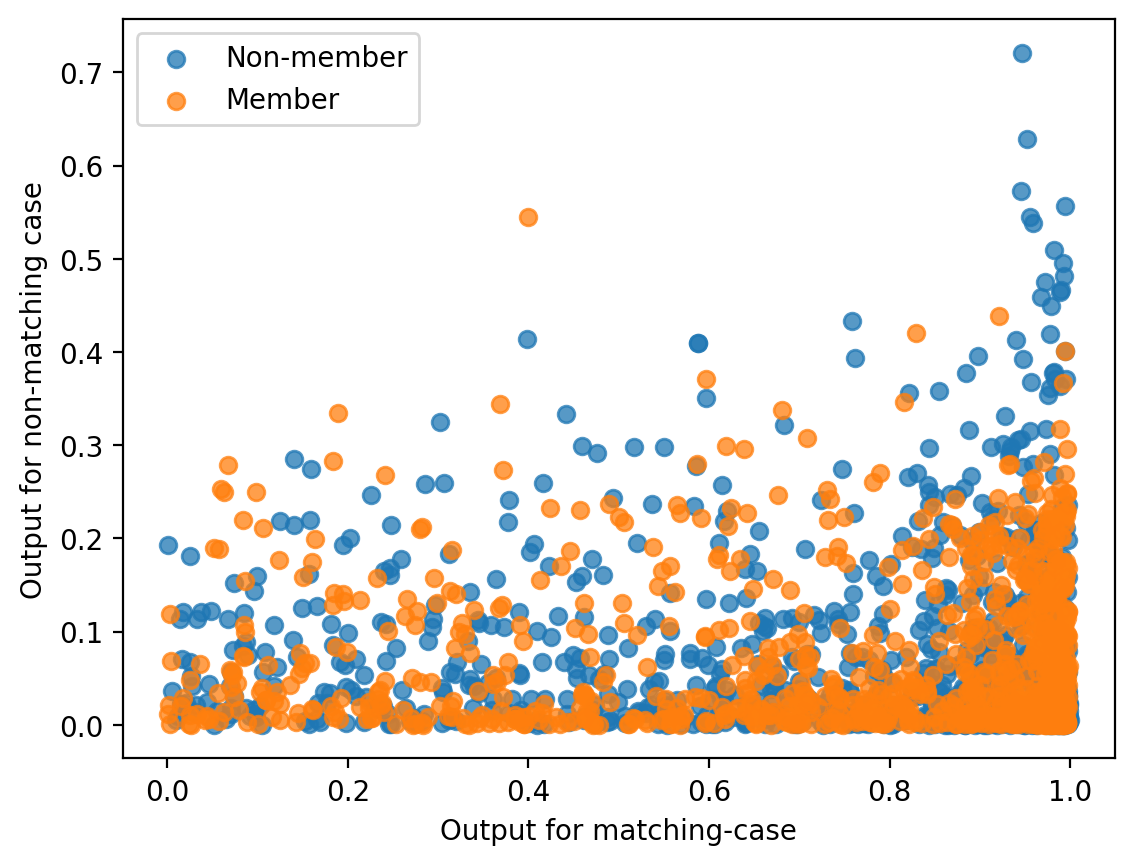

In [89]:
picked = (0, 1)
plt.scatter(nonmem[:, picked[0]], nonmem[:, picked[1]], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem[:, picked[0]], mem[:, picked[1]], label="Member", color="C1", alpha=0.75)
plt.xlabel("Output for matching-case")
plt.ylabel("Output for non-matching case")
plt.legend()

In [ ]:
# for creating a responsive plot
# %matplotlib notebook

In [71]:
mem, nonmem = experiment(ds_adv, ds_vic, model_paths[index], n_people=100, skip_plot=True, tsne_dim=2, use_relation=True)

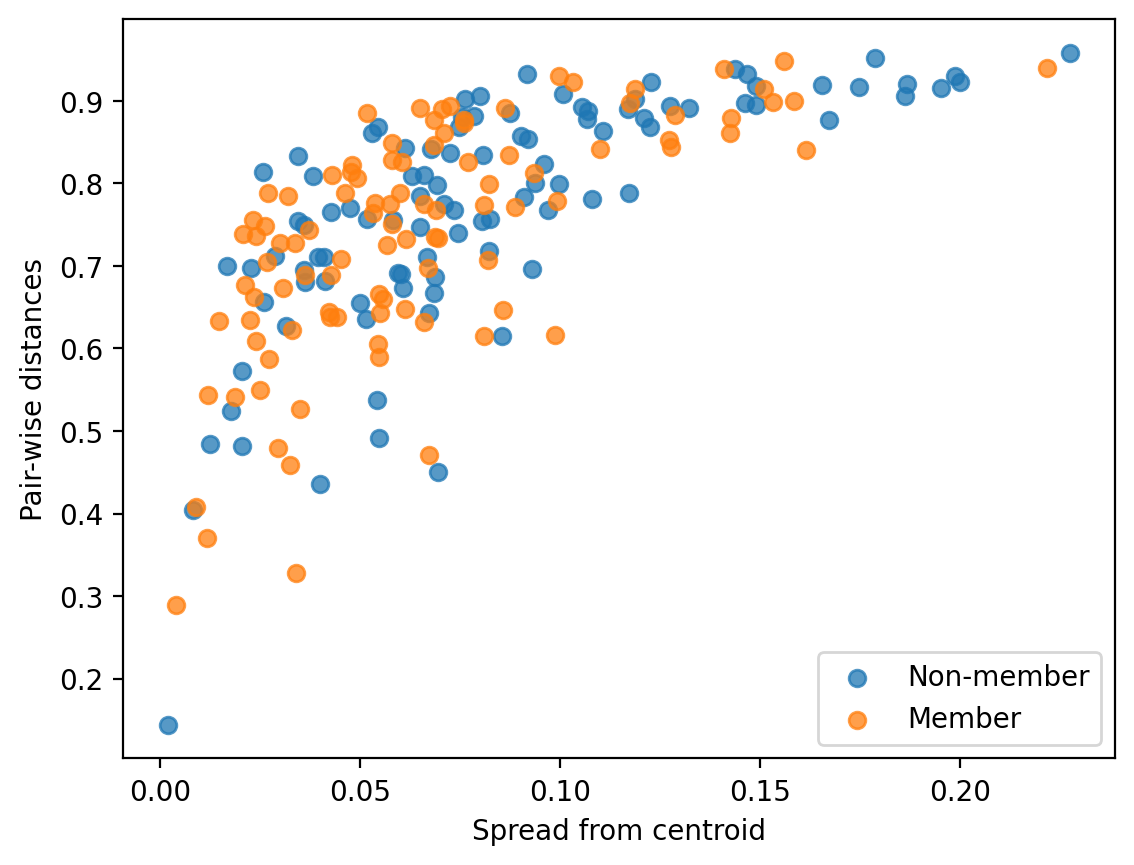

In [72]:
picked = (0, 1)
plt.scatter(nonmem[:, picked[0]], nonmem[:, picked[1]], label="Non-member", color="C0", alpha=0.75)
plt.scatter(mem[:, picked[0]], mem[:, picked[1]], label="Member", color="C1", alpha=0.75)
plt.xlabel("Spread from centroid")
plt.ylabel("Pair-wise distances")
plt.legend()

In [ ]:
plt.hist(nonmem, bins=21, alpha=0.5, label="Non-members")
plt.hist(mem, bins=21, alpha=0.5, label="Members")
plt.legend()

In [ ]:
nonmem

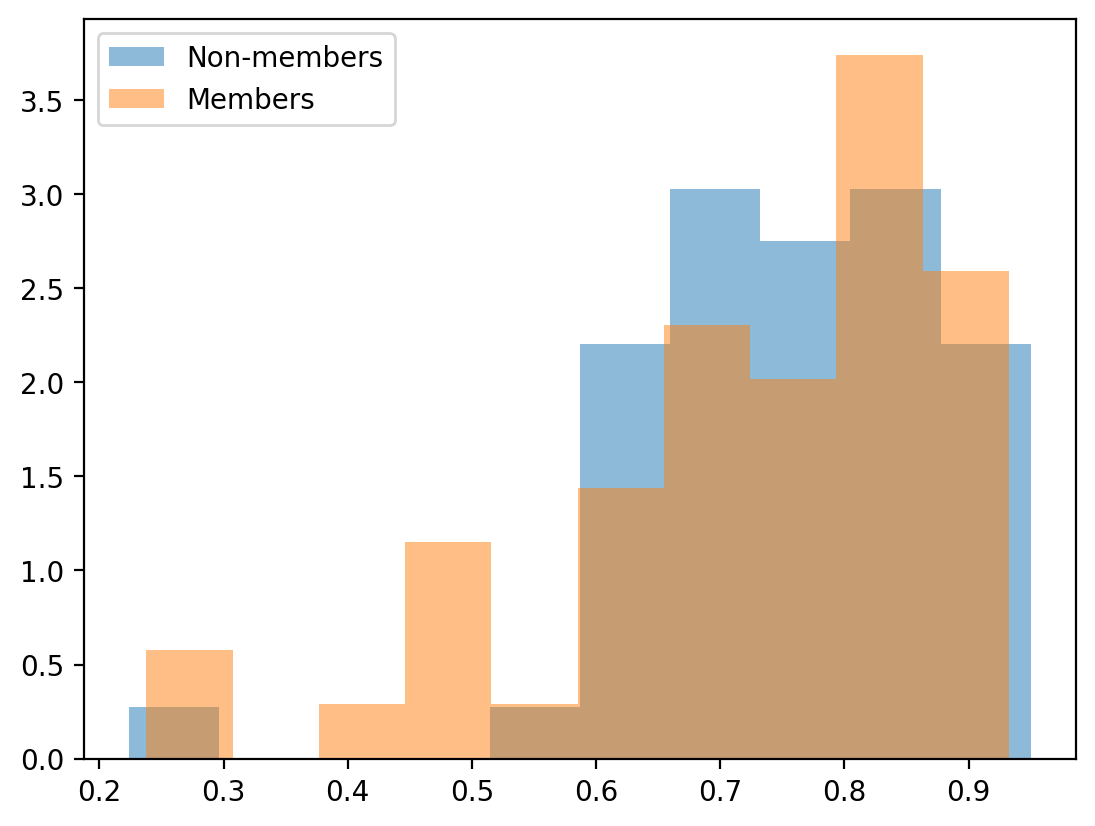

In [63]:
plt.hist(nonmem[:, 1], bins=10, alpha=0.5, label="Non-members", density=True)
plt.hist(mem[:, 1], bins=10, alpha=0.5, label="Members", density=True)
plt.legend()